# ECON 8185 - HW 3

João Lazzaro - santo279@umn.edu

## Question 1

In this question we were asked to write a code to compute the MLE estimator for the parameters of HW2 model: 

$$\max_{c_t,x_t,l_t} E \sum_{t=0}^\infty \beta^t \frac{\left(c_tl_t^\psi\right)^{1-\sigma}}{1-\sigma} N_t$$
S.T. 
$$ c_t +(1+\tau_{xt})x_t =r_t k_t +(1-\tau_{ht})w_t h_t + T_t$$
$$ N_{t+1} k_{t+1} = [(1-\delta)k_t+x_t]N_t$$
$$h_t+l_t =1$$
$$S_t = P S_{t-1}+Q\epsilon_t,\;\;S_t = [\ln z_t,\tau_{ht},\tau_{xt}, \ln g_t]$$
$$ c_t,x_t\geq0$$

Where $N_t = (1+\gamma_n)^t$ and firm tecnhology is $Y_t = K_t^\theta (Z_t L_t)^{1-\theta}$. $\gamma_z$ is the rate of labor-augmenting technical progress. The stochastic shocks hitting this economy affect technology, tax rates, and government spending and the stochastic processes are modeled as a VAR(1) process. The resource constraint is $Y_t=N_t(c_t +x_t +g_t)$. We must work with detrended variables, we should use "hat" variables, but typing this is time consuming so from now on all variables should be understood as detrended unless I say something about them.

Let's first define some parameters for this model:

In [ ]:
Threads.nthreads()

In [1]:
using NLsolve, ForwardDiff, LinearAlgebra, Random, JLD2,FileIO
using Optim, Statistics, NLSolversBase,LaTeXStrings, Plots

#Parameters:
δ = 0.0464   #depreciation rate
θ = 1/3  #capital share of output
β = 0.9  #Discouting
σ = 2  #Elasticity of Intertemporal Substitution
ψ = 1    #Labor parameter
γn= 0.00    #Population growth rate
γz= 0.00   #Productivitu growth rate

0.0

We'll assume, for now, that matrices P and Q are the following:

In [2]:
#Parameters to be estimated and here used in our simulated example
gss = log(0.01) #average g (in logs)
τxss = 0.05 #average τx
τhss = 0.02 #average τh
zss = log(1) #average z (z is in logs)

#Parameters to be estimated
ρg = 0.8
ρx = 0.5
ρh = 0.5
ρz = 0.9
ρzg= 0.0
ρzx = 0.0
ρzh = 0.0
ρhz = 0.0
ρhx = 0.0
ρhg = 0.0
ρxz = 0.0
ρxh = 0.0
ρxg = 0.0
ρgz = 0.0
ρgx = 0.4
ρgh = 0.4

σg= 0.02
σx = 0.01
σz = 0.05
σh = 0.01
σzg= 0.0
σzx = 0.00
σzh = 0.00
σhx = 0.00
σhg = 0.004
σxg = 0.004

#In matrix form
P = [ρz ρzh ρzx ρzg;
ρhz ρh ρhx ρhg ;
ρxz ρxh ρx ρxg ;
ρgz ρgh ρgx ρg]
Q = [σz σzh σzx σzg;
σzh σh σhx σhg ;
σzx σhx σx σxg ;
σzg σhg σxg σg]
P,Q

([0.9 0.0 0.0 0.0; 0.0 0.5 0.0 0.0; 0.0 0.0 0.5 0.0; 0.0 0.4 0.4 0.8], [0.05 0.0 0.0 0.0; 0.0 0.01 0.0 0.004; 0.0 0.0 0.01 0.004; 0.0 0.004 0.004 0.02])

In HW2, I describe how to approximate and write the model in the state space form:
$$ X_{t+1} = AX_t + B \varepsilon_{t+1}$$
$$Y_t = CX_t+\omega_t$$
Where, $X_t = [k_t,S_t],S_t=[z_t,\tau_{ht},\tau_{xt},g_t]$, $Y_t = [y_t,x_t,h_t]$ and as before:
$$S_{t+1} = P S_t +Q \varepsilon_{t+1}$$

The function below, defined in HW2, finds Matrices $A,B$ and $C$, given pthe parameters:

In [3]:
include("State_Space.jl")

params_calibrated = [δ,θ,β,σ,ψ,γn,γz,]
steadystates = [gss,τxss,τhss,zss]

A,B,C = State_Space(params_calibrated,steadystates, P,Q)

([0.837775 0.135621 … -0.00413272 -0.000178255; 0.0 0.9 … 0.0 0.0; … ; 0.0 0.0 … 0.5 0.0; 0.0 0.0 … 0.4 0.8], [0.0 0.0 … 0.0 0.0; 0.0 0.05 … 0.0 0.0; … ; 0.0 0.0 … 0.01 0.004; 0.0 0.0 … 0.004 0.02], [0.462735 0.749104 … -0.00343496 0.00671295; -2.49623 2.92287 … -0.0890666 -0.00384172; 0.1941 0.123655 … -0.00515238 0.0100694; 0.0 0.0 … 0.0 1.0])

Given the model we simulate some data:

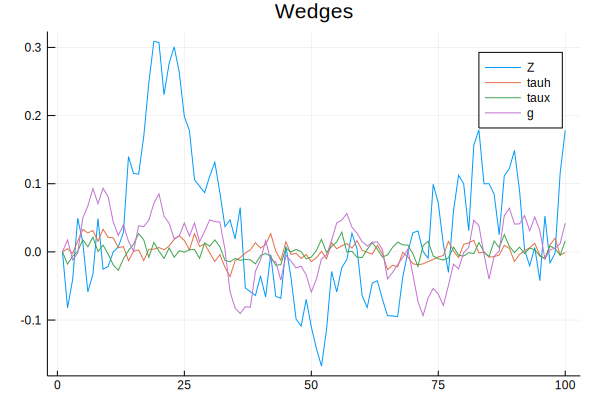

In [4]:
T=100
X= zeros(5,T)
Y = zeros(4,T)

Random.seed!(0403);
S = randn(5,T) #vector with shocks

#Simulating data
for t=1:T
    if t>1
    X[:,t] = A*X[:,t-1]+ B*S[:,t]
    end
    Y[:,t] = C*X[:,t]
end
plot([X[2,:],X[3,:],X[4,:],X[5,:]],title ="Wedges", labels = ["Z","tauh","taux","g"])

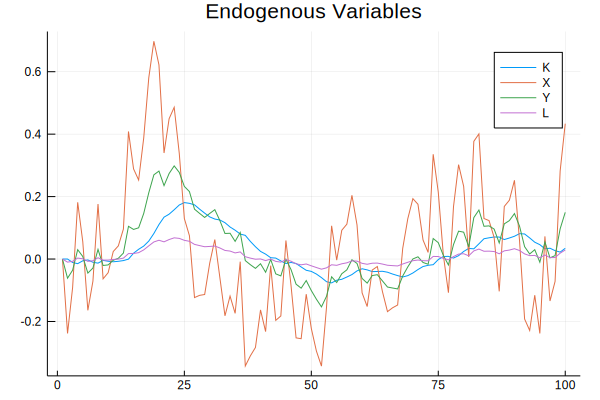

In [5]:
plot([X[1,:],Y[2,:],Y[1,:],Y[3,:]],title = "Endogenous Variables",labels = ["K","X","Y","L"])

Given the simulated data above, we want to build an algorithm to estimate the matrices P and Q (and the steady state values) such that we would have the same data generating process. To do that, we'll build a likelihood function using the Kalman Filter. We follow Ljunqvist & Sargent exposition of the Kalman filter. Assume for a slightly more general case that $\omega_t$ is an iid vector sequence of normal random variances with mean zero and covariance matrix $R$ (In our case, $R=0$).  

We observe $Y_t$ but not $X_t$. We want to estimate $\hat{X}_t = E[X_t|Y^{t-1}]$ and also the covariances $\Sigma_t = E[(X_t-\hat{X}_t)(X_t-\hat{X}_t)']$. The trick is to use the new information in $y_0$ relative to what we know ($\hat{X}_0$):    $a_0:=Y_0-C\hat{X}_0$. $a_t:=Y_t-C\hat{X}_t$. Regressing the model: $$X_0-\hat{X}_0 = L_0a_0+\eta$$ We get that:
$$L_0 = \Sigma_0 C'\left(C\Sigma_0 C'+R\right)^{-1} $$

Defining $\hat{X}_1 = E[X_1|Y_0] = A X_0$: 
$$X_1 = A\hat{X}_0 + A\left(X_0-\hat{X}_0\right) + B \varepsilon_1$$

Substituting the linear model and $L_0$:
$$\hat{X}_1 = A\hat{X}_0 +K_0(Y_0 - C \hat{X}_0) $$

Where $K_0 = AL_0$ is the Kalman gain. Plugging these equations: $X_1-\hat{X}_1 = A (X_0-\hat{X}_0) +B \varepsilon_1 - K_0(Y_0-C\hat{X}_0)$ and we may compute a new variance matrix $\Sigma_1 = E(X_1-\hat{X}_1)(X_1-\hat{X}_1)$:
$$\Sigma_1 = (A-K_0C)\Sigma_0(A-K_0C)' + (BB'+K_0RK_0')$$


Iterating the above steps we get te Kalman filter recursion:
$$a_t = Y_t-C\hat{X}_t$$
$$K_t = A\Sigma_tC'(C\Sigma_tC'+R)^{-1}$$
$$\hat{X}_{t+1} = A\hat{X}_t + K_t a_t$$
$$\Sigma_{t+1} = (A-K_tC)\Sigma_t(A-K_tC)' + (BB'+K_tRK_t')$$

The code below implements this recursion:

In [11]:
function KalmanFilter(Y,A,B,C)
#Y: Observed variables


n = size(A)[1] #number of state variables
m = size(C)[1] #number of measurement variables
T = size(Y)[2] #Sample size

#Initializing the state variables
X = zeros(n,T)
#Variance initial guess
Σ = ones(n,n)*ones(n,n)'
d=10
while d>10^(-15)
    Σ1 = A*Σ*A' + B*B'
    d = maximum(abs.(Σ-Σ1))
    Σ=Σ1
end

#Run the Kalman filter algorithm (see Ljunqvist sargent)
a=ones(m,T)
Ω = C*Σ*C'
Σhist = copy(Σ)
for t = 1:T-1
    a[:,t] = Y[:,t] - C*X[:,t]
    K = A*Σ*C' / (C*Σ*C')
    X[:,t+1] = A*X[:,t] +K*a[:,t]
    Σ = B*B' + (A-K*C)*Σ*(A-K*C)'
    Σhist = [Σhist Σ]
    Ω = [Ω C*Σ*C']
end
a[:,T] = Y[:,T] - C*X[:,T]
Ω = [Ω C*Σ*C']

return X, a, Ω, Σhist
end

KalmanFilter (generic function with 1 method)

Note that we set, in the code above, the initial $\Sigma_0$ such that $\Sigma_0 = A\Sigma_0A' +BB$. 

The innovations representation that emerges from the Kalman filter is: 
$$\hat{X}_{t+1} = A\hat{X}_t+K_t a_t$$
$$Y_t = C \hat{X}_t +a_t $$
Define: $\Omega_t :=E[a_ta'_t] = C \Sigma_tC'+R$. We have that $E[Y_t|Y^{t-1}] = C\hat{X}_t$ and the conditional distribution of $Y_t$ is $N(C\hat{X}_t,\Omega_t)$. Therefore, $C\hat{X}_t,\Omega_t$ are sufficient statistics for the conditional distribution of $Y_t$. Note that we can factor the likelihood function as:
$$f(Y_T,...Y_0) = f(Y_T|Y^{T-1})f(Y_{T-1}|Y^{T-2})...f(Y_1|Y_0)f(Y_0)$$

And the log of the conditional density of the $m \times 1$ vector $Y_t$, ignoring constant terms, is:
$$\log f(Y_t|Y^{t-1}) =- 0.5 \log(|\Omega_t|) -0.5 a_t'\Omega_t^{-1} a_t$$

The code below builds the log conditional likelihood function using the method above:

In [3]:
function likelihood(Y,Ω,a)
    m,T = size(Y)
    L = 0
for t=1:T
    iteration = t
    L = L + (-0.5*log(det(Ω[:,m*t-(m-1):(m*t)])) -
    0.5*a[:,t]'*(Ω[:,m*t-(m-1):(m*t)]\a[:,t]))
end
return L
end

likelihood (generic function with 1 method)

We can estimate parameters $\theta$ given a vector of data $Y$ by maximizing the log likelihood function. I've tried to use standard Newton methods approach to do it but the results were poor since the Likelihood function often has multiple local maxima. I will try something different: the Expectation Maximization (EM) algorithm. I follow Shumway & Stoffer 4ed textbook for the EM algorithm.

Let $f(X,Y;\theta)$ be the joint distribution under parameters $\theta$. The EM algorithm is the following steps:

Expectation Step: $$Q(\theta,\theta_t) = E_{\theta_t}[\log f(X,Y;\theta) |Y =y]$$
Maximization Step: $$ \theta_{t+1} = \arg\max_\theta Q(\theta,\theta_t)$$

We can show that the state space model joint log-likelihood, ignoring constants, is given by:

$$ \log L(X,Y;\theta) = -\frac{1}{2} \left( (X_0-\mu_0)'\Sigma_0^{-1} (X_0-\mu_0) + T \log |B| + \sum_{t=1}^T (X_t-AX_{t-1})'B^{-1} (X_t-AX_{t-1}) + T\log |R| + \sum_{t=1}^T (Y_t-CX_t)'R^{-1} (Y_t-CX_t)'\right)$$

Taking conditional expectations of the function above, we get our expression for $Q$. But in order to derive the expression for $Q$, we need to define the Kalman Smoother, which tackles the problem of getting an estimate for $X_t$, given the entire data sample $Y^T$, not only $Y^t$ as in the Kalman filter. Let's introduce some new notation: $\hat{X}^s_t = E[X_t|Y^s]$. Note that $\hat{X}_t^t$ is the filtered value for $X$. 
The Kalman Smoother is given by the Following recursion:

$$\hat{X}_{t-1}^T = \hat{X}_{t-1}^{t-1} + J_{t-1}(\hat{X}_{t}^T - A\hat{X}_{t-1}^{t-1})$$
$$\Sigma_{t-1}^T =\Sigma_{t-1} + J_{t-1}(\Sigma_{t}^T - A\Sigma_{t-1}A'+B)J_{t-1}'$$
$$J_{t-1} = \Sigma_{t-1} A'(A\Sigma_{t-1}A'+B)^{-1}$$

The code below implements the Kalman Smoother:

In [10]:
function KalmanSmoother(X,Σhist,A,B;K=K)
    #X are the filtered values from the Kalman filters
    #Ω contains all the Σ matrices from the Kalman filter
    T = size(X)[2] #Sample size
    m = size(Σhist)[1]
    Xsmooth = copy(X)
    Σsmooth = copy(Σhist)
    for t=T:-1:2
        J = Σhist[:,m*(t-1)-(m-1):(m*(t-1))]*A'/(A*Σhist[:,m*(t-1)-(m-1):(m*(t-1))]*A'+B)
        Xsmooth[:,t-1] = X[:,t-1]+J*(Xsmooth[:,t]- A*X[:,t])
        Σsmooth[:,m*(t-1)-(m-1):(m*(t-1))] =  Σhist[:,m*(t-1)-(m-1):(m*(t-1))] + J * ( Σsmooth[:,m*t-(m-1):(m*t)]-A*Σhist[:,m*(t-1)-(m-1):(m*(t-1))]*A'+B)*J'
    end
    return Xsmooth,Σsmooth
end
    

KalmanSmoother (generic function with 1 method)

Define:
$$\Sigma^T_{T,T-1} := (I-K_TC)A\Sigma_{T-1} $$
$$\Sigma^T_{t-1,t-2} := \Sigma_{t-1} J'_{t-2} + J_{t-1}\left(\Sigma^T_{t,t-1}- A \Sigma_{t-1}\right) J'_{t-2}$$
$$S_{11} := \sum_{t=1}^T\left(\hat{X}_t^T(\hat{X}_t^{T})' + \Sigma^T_t\right)$$
$$S_{10} = \sum_{t=1}^T\left(\hat{X}_t^T(\hat{X}_{t-1}^{T})' + \Sigma^T_{t,t-1}\right)$$
$$S_{00} = \sum_{t=1}^T\left(\hat{X}_{t-1}^T(\hat{X}_{t-1}^{T})' + \Sigma^T_{t-1}\right)$$

Q is defined as: 
$$Q(\theta,\theta_{t-1}) = \log |\Sigma_0| + tr\{\Sigma_0^{-1} [ 
\Sigma^T_0 + (X^T_0 -\mu_0)(X^T_0-\mu_0)']\} + T \log|B| + tr\{B^{-1}[S_{11}-S_{10}A'-AS_{10}'+AS_{00}A']\} +T\log |R| + tr\{R^{-1} \sum_{t=1}^T [ (Y_T-C X^T_t)(Y_t - ACX^T_t)' + C_t \Sigma_t^T A_t']\} $$

Minimizing the expression above is the M step of the EM algorithm. But we do not do this directly. Since the joint distribution is normal, we, by usual regression analysis, that update estimates are given by:

$$ A^j = S_{10}S_{00}^{-1} $$
$$ B^j = T^{-1}\left(S_{11} - S_{10}S_{00}^{-1}S_{10}'\right)$$
$$R^j = T^{-1}\sum_{t=1}^T [ (Y_T-C X^T_t)(Y_t - ACX^T_t)' + C_t \Sigma_t^T A_t']$$

$\mu^j_0 = x^T_0$

Now, back to our exercise, the code below we may define the subset of parameters to be estimated and writes down a function to in the optimizer format.

In [8]:
function maxloglikelihood(vector::Vector;Y=Y)
    #ρg,ρx,ρh,ρz,σg,σx,σz,σh=vector
    ρg,ρx,ρh,ρz=vector
    #ρg,ρx,ρh,ρz,ρzg,ρzx,ρzh,ρhz,ρhx,ρhg,ρxz,ρxh,ρxg,ρgz,ρgx,ρgh,σg,σx,σz,σh,σzg,σzx,σzh,σhx,σhg,σxg,gss,τxss,τhss,zss = vector
    #ρg,ρx,ρh,ρz,ρzg,ρzx,ρzh,ρhz,ρhx,ρhg,ρxz,ρxh,ρxg,ρgz,ρgx,ρgh,σg,σx,σz,σh,σzg,σzx,σzh,σhx,σhg,σxg = vector

    #In matrix form
    P = [ρz ρzh ρzx ρzg;
    ρhz ρh ρhx ρhg ;
    ρxz ρxh ρx ρxg ;
    ρgz ρgh ρgx ρg]

    Q = [σz σzh σzx σzg;
    σzh σh σhx σhg ;
    σzx σhx σx σxg ;
    σzg σhg σxg σg]

    steadystates = gss,τxss,τhss,zss
    params_calibrated = [δ,θ,β,σ,ψ,γn,γz]


    A,B,C = State_Space(params_calibrated,steadystates, P,Q)
    X, a, Ω = KalmanFilter(Y,A,B,C)
    L = -likelihood(Y,Ω,a)
    return L
end

maxloglikelihood (generic function with 1 method)

Note that the function above actually returns minus the log likelihood, since our optimizer is in fact a minimizer. Checking the value of 

## Question 2

We first begin estimating only 4 parameters and assuming all the others are known:

In [9]:
original = [ρg,ρx,ρh,ρz]

4-element Array{Float64,1}:
 0.8
 0.5
 0.5
 0.9

The likelihood valued at the true parameters is:

In [10]:
truelikelihood = maxloglikelihood(original)

-1783.9194217380602

Our optimizer will use the LBFGS which is a variant of the Newton method with approximated Hessians and Gradients (see Judd's book for a BFGS explanation and Optim's documentation for LBFGS). Also, we'll only allow the optimizer to choose parameters that make sense. Our initial guess will be points normally distributed around the true ones.

In [13]:
Random.seed!(0403);
initial = original .+ randn(length(original))*0.5

#Solver Stuff
inner_optimizer = LBFGS() #LBFGS()  # SimulatedAnnealing() #NelderMead() ConjugateGradient()

#Defining lower and upper bounds for estimator
lower=zeros(length(initial))
upper = ones(length(initial))
#making sure that the initial guess is within the bounds
initial = min.(upper.*0.99,initial)
initial = max.(lower.+0.0001,initial)


@time bla = optimize(maxloglikelihood,lower,upper, initial,Fminbox(inner_optimizer), Optim.Options(show_trace = false, show_every = 10,iterations =500, time_limit = 60*60*1.0))
estimates = bla.minimizer

  3.445633 seconds (5.60 M allocations: 851.291 MiB, 9.96% gc time)


4-element Array{Float64,1}:
 0.22411043812249876
 0.6547286886737138 
 0.2476351905441793 
 0.9011896923082203 

The optimizer found the parameters above, note that they are reasonably, close to the true parameters:

In [14]:
abs.(estimates - original)

4-element Array{Float64,1}:
 0.5758895618775013   
 0.1547286886737138   
 0.25236480945582074  
 0.0011896923082203026

Now we repeat the exercise increasing the sample size:

In [16]:
T=600
X= zeros(5,T)
Y = zeros(4,T)

Random.seed!(0403);
S = randn(5,T) #vector with shocks

#Simulating data
for t=1:T
    if t>1
    X[:,t] = A*X[:,t-1]+ B*S[:,t]
    end
    Y[:,t] = C*X[:,t]
end

Random.seed!(0403);
initial = original .+ randn(length(original))*0.5

#Solver Stuff
inner_optimizer = LBFGS() #LBFGS()  # SimulatedAnnealing() #NelderMead() ConjugateGradient()

#Defining lower and upper bounds for estimator
lower=zeros(length(initial))
upper = ones(length(initial))
#making sure that the initial guess is within the bounds
initial = min.(upper.*0.99,initial)
initial = max.(lower.+0.0001,initial)


bla = optimize(maxloglikelihood,lower,upper, initial,Fminbox(inner_optimizer),Optim.Options(show_trace = false, show_every = 10,iterations =500, time_limit = 60*60*1.0))
estimates = bla.minimizer

4-element Array{Float64,1}:
 0.7984436257410532
 0.5068017677547227
 0.512274213064898 
 0.8999509872619331

The estimation improved considerably for most parameters:

In [17]:
abs.(estimates - original)

4-element Array{Float64,1}:
 0.0015563742589468355
 0.006801767754722743 
 0.012274213064897954 
 4.901273806690032e-5 

We keep this new sample size and now, we estimate 8 parameters in total:

In [18]:
function maxloglikelihood(vector::Vector;Y=Y)
    ρg,ρx,ρh,ρz,σg,σx,σz,σh=vector
    #ρg,ρx,ρh,ρz=vector
    #ρg,ρx,ρh,ρz,ρzg,ρzx,ρzh,ρhz,ρhx,ρhg,ρxz,ρxh,ρxg,ρgz,ρgx,ρgh,σg,σx,σz,σh,σzg,σzx,σzh,σhx,σhg,σxg,gss,τxss,τhss,zss = vector
    #ρg,ρx,ρh,ρz,ρzg,ρzx,ρzh,ρhz,ρhx,ρhg,ρxz,ρxh,ρxg,ρgz,ρgx,ρgh,σg,σx,σz,σh,σzg,σzx,σzh,σhx,σhg,σxg = vector

    #In matrix form
    P = [ρz ρzh ρzx ρzg;
    ρhz ρh ρhx ρhg ;
    ρxz ρxh ρx ρxg ;
    ρgz ρgh ρgx ρg]

    Q = [σz σzh σzx σzg;
    σzh σh σhx σhg ;
    σzx σhx σx σxg ;
    σzg σhg σxg σg]

    steadystates = gss,τxss,τhss,zss
    params_calibrated = [δ,θ,β,σ,ψ,γn,γz]


    A,B,C = State_Space(params_calibrated,steadystates, P,Q)
    X, a, Ω = KalmanFilter(Y,A,B,C)
    L = -likelihood(Y,Ω,a)
    return L
end

maxloglikelihood (generic function with 1 method)

The parameters being estimated are:

In [19]:
original = [ ρg,ρx,ρh,ρz,σg,σx,σz,σh]

8-element Array{Float64,1}:
 0.8 
 0.5 
 0.5 
 0.9 
 0.02
 0.01
 0.05
 0.01

In [20]:
Random.seed!(0403);
initial = original .+ randn(length(original))*0.5

#Solver Stuff
inner_optimizer = LBFGS() #LBFGS()  # SimulatedAnnealing() #NelderMead() ConjugateGradient()

#Defining lower and upper bounds for estimator
lower=zeros(length(initial))
upper = ones(length(initial))
#making sure that the initial guess is within the bounds
initial = min.(upper.*0.99,initial)
initial = max.(lower.+0.0001,initial)


bla = optimize(maxloglikelihood,lower,upper, initial,Fminbox(inner_optimizer),
    Optim.Options(show_trace = false, show_every = 10,iterations =500, time_limit = 60*60*1.0))
estimates = bla.minimizer

8-element Array{Float64,1}:
 0.793628681730038   
 0.6736785643705833  
 0.4557832869970009  
 0.8999417740025389  
 0.019453365325372833
 0.01718884220554578 
 0.04916784460096986 
 0.009953386510255133

The estimation is also good, but for one parameter it is way off.

In [21]:
abs.(estimates - original)

8-element Array{Float64,1}:
 0.006371318269962067 
 0.17367856437058327  
 0.04421671300299912  
 5.8225997461081036e-5
 0.0005466346746271673
 0.007188842205545781 
 0.0008321553990301434
 4.661348974486709e-5 

Now, we estimate all the Parameters with the exception of the Steady States and things start to get a little trickier:

In [22]:
function maxloglikelihood(vector::Vector;Y=Y)
    #ρg,ρx,ρh,ρz,σg,σx,σz,σh=vector
    #ρg,ρx,ρh,ρz=vector
    #ρg,ρx,ρh,ρz,ρzg,ρzx,ρzh,ρhz,ρhx,ρhg,ρxz,ρxh,ρxg,ρgz,ρgx,ρgh,σg,σx,σz,σh,σzg,σzx,σzh,σhx,σhg,σxg,gss,τxss,τhss,zss = vector
    ρg,ρx,ρh,ρz,ρzg,ρzx,ρzh,ρhz,ρhx,ρhg,ρxz,ρxh,ρxg,ρgz,ρgx,ρgh,σg,σx,σz,σh,σzg,σzx,σzh,σhx,σhg,σxg = vector

    #In matrix form
    P = [ρz ρzh ρzx ρzg;
    ρhz ρh ρhx ρhg ;
    ρxz ρxh ρx ρxg ;
    ρgz ρgh ρgx ρg]

    Q = [σz σzh σzx σzg;
    σzh σh σhx σhg ;
    σzx σhx σx σxg ;
    σzg σhg σxg σg]

    steadystates = gss,τxss,τhss,zss
    params_calibrated = [δ,θ,β,σ,ψ,γn,γz]


    A,B,C = State_Space(params_calibrated,steadystates, P,Q)
    X, a, Ω = KalmanFilter(Y,A,B,C)
    L = -likelihood(Y,Ω,a)
    return L
end

maxloglikelihood (generic function with 1 method)

In [23]:
original = [ ρg,ρx,ρh,ρz,ρzg,ρzx,ρzh,ρhz,ρhx,ρhg,ρxz,ρxh,ρxg,ρgz,ρgx,ρgh,σg,σx,σz,σh,σzg,σzx,σzh,σhx,σhg,σxg]

26-element Array{Float64,1}:
 0.8  
 0.5  
 0.5  
 0.9  
 0.0  
 0.0  
 0.0  
 0.0  
 0.0  
 0.0  
 0.0  
 0.0  
 0.0  
 0.0  
 0.4  
 0.4  
 0.02 
 0.01 
 0.05 
 0.01 
 0.0  
 0.0  
 0.0  
 0.0  
 0.004
 0.004

In [24]:
Random.seed!(0403);
initial = original .+ randn(length(original))*0.1


#Solver Stuff
inner_optimizer = LBFGS() #LBFGS()  # SimulatedAnnealing() #NelderMead() ConjugateGradient()


#Defining lower and upper bounds for estimator
lower=zeros(length(initial))

upper = ones(length(initial))
if length(initial) == 8
    upper[5:8] = 0.05 *ones(4)
end
if length(initial)>16
    upper[17:26] = 0.05.*ones(10)
    lower[5:16] = -1*ones(12)
end
if length(initial) == 30
    upper[27:30] = 0.1 * ones(4)
    lower[30] = -100 #z lower bound (in logs)
    lower[27] = -100 #g lower bound (in logs)
end
#making sure that the initial guess is within the bounds
initial = min.(upper.*0.99,initial)
initial = max.(lower.+0.0001,initial)


bla = optimize(maxloglikelihood,lower,upper, initial,Fminbox(inner_optimizer),Optim.Options(show_trace = false, show_every = 5,iterations =500, time_limit = 60*60*1.0))

estimates = bla.minimizer

26-element Array{Float64,1}:
  0.7847573879497515    
  0.5712150595077666    
  0.6022347695994222    
  0.8997600169596675    
  0.04692875467196209   
 -0.00216051519431645   
 -0.16318955143318173   
  0.004571919453038248  
 -0.21529447573382796   
  0.13105687965131052   
  0.014573736805809244  
  0.0651906226087065    
 -0.009534342297567309  
  0.10785083364289334   
  0.27234959800866004   
  0.4876258142132673    
  0.0248170226037271    
  0.016763726441233154  
  0.04988045971552021   
  5.346737300811821e-7  
  1.114877822129582e-10 
  0.0009365205967434558 
  2.1255702509722693e-23
  0.012944745725048118  
  0.001722777629999073  
  6.862268798995851e-56 

The estimates are fair:

In [25]:
abs.(estimates - original)

26-element Array{Float64,1}:
 0.015242612050248572  
 0.07121505950776663   
 0.10223476959942224   
 0.00023998304033256979
 0.04692875467196209   
 0.00216051519431645   
 0.16318955143318173   
 0.004571919453038248  
 0.21529447573382796   
 0.13105687965131052   
 0.014573736805809244  
 0.0651906226087065    
 0.009534342297567309  
 0.10785083364289334   
 0.12765040199133998   
 0.08762581421326726   
 0.0048170226037271    
 0.006763726441233154  
 0.0001195402844797952 
 0.00999946532626992   
 1.114877822129582e-10 
 0.0009365205967434558 
 2.1255702509722693e-23
 0.012944745725048118  
 0.0022772223700009272 
 0.004                 

Now, estimating all the 30 parameters:

In [26]:
function maxloglikelihood(vector::Vector;Y=Y)
    #ρg,ρx,ρh,ρz,σg,σx,σz,σh=vector
    #ρg,ρx,ρh,ρz=vector
    ρg,ρx,ρh,ρz,ρzg,ρzx,ρzh,ρhz,ρhx,ρhg,ρxz,ρxh,ρxg,ρgz,ρgx,ρgh,σg,σx,σz,σh,σzg,σzx,σzh,σhx,σhg,σxg,gss,τxss,τhss,zss = vector
    #ρg,ρx,ρh,ρz,ρzg,ρzx,ρzh,ρhz,ρhx,ρhg,ρxz,ρxh,ρxg,ρgz,ρgx,ρgh,σg,σx,σz,σh,σzg,σzx,σzh,σhx,σhg,σxg = vector

    #In matrix form
    P = [ρz ρzh ρzx ρzg;
    ρhz ρh ρhx ρhg ;
    ρxz ρxh ρx ρxg ;
    ρgz ρgh ρgx ρg]

    Q = [σz σzh σzx σzg;
    σzh σh σhx σhg ;
    σzx σhx σx σxg ;
    σzg σhg σxg σg]

    steadystates = gss,τxss,τhss,zss
    params_calibrated = [δ,θ,β,σ,ψ,γn,γz]


    A,B,C = State_Space(params_calibrated,steadystates, P,Q)
    X, a, Ω = KalmanFilter(Y,A,B,C)
    L = -likelihood(Y,Ω,a)
    return L
end

maxloglikelihood (generic function with 1 method)

In [27]:
original = [ρg,ρx,ρh,ρz,ρzg,ρzx,ρzh,ρhz,ρhx,ρhg,ρxz,ρxh,ρxg,ρgz,ρgx,ρgh,σg,σx,σz,σh,σzg,σzx,σzh,σhx,σhg,σxg,gss,τxss,τhss,zss]

30-element Array{Float64,1}:
  0.8              
  0.5              
  0.5              
  0.9              
  0.0              
  0.0              
  0.0              
  0.0              
  0.0              
  0.0              
  0.0              
  0.0              
  0.0              
  ⋮                
  0.05             
  0.01             
  0.0              
  0.0              
  0.0              
  0.0              
  0.004            
  0.004            
 -4.605170185988091
  0.05             
  0.02             
  0.0              

In [ ]:
Random.seed!(0403);
initial = original .+ randn(length(original))*0.15
initial[5:30] = original[5:30] .+randn(length(original[5:30]))*0.05



#Solver Stuff
inner_optimizer = LBFGS() #LBFGS()  # SimulatedAnnealing() #NelderMead() ConjugateGradient()


#Defining lower and upper bounds for estimator
lower=zeros(length(initial))

upper = ones(length(initial))
if length(initial) == 8
    upper[5:8] = 0.05 *ones(4)
end
if length(initial)>16
    upper[17:26] = 0.05.*ones(10)
    lower[5:16] = -1*ones(12)
end
if length(initial) == 30
    upper[27:30] = 0.1 * ones(4)
    lower[30] = -100 #z lower bound (in logs)
    lower[27] = -100 #g lower bound (in logs)
end
#making sure that the initial guess is within the bounds
initial = min.(upper.*0.99,initial)
initial = max.(lower.+0.0001,initial)


bla = optimize(maxloglikelihood,lower,upper, initial,Fminbox(inner_optimizer),Optim.Options(show_trace = false, show_every = 5,iterations =500, time_limit = 60*60*1.0))

estimates = bla.minimizer

Assessing the accuracy:

In [ ]:
abs.(estimates - original)

Although my maximization algorithm works, it is extremely sensible to initial conditions. I was assuming that my initial guesses were normally distributed around the Steady States. I had to decrease the dispersion while I increased the number of estimated parameters since it was common to the optimizer to converge to a local minimum, but the main issue is that with some weird parameters combinations the model is not well defined (explosive procesess and non-invertible matrices) returning errors. 